In [1]:
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import numpy as np
from os import scandir, walk, remove
import pandas as pd
from fastprogress import progress_bar
from fastai import *
from fastai.vision import *
from PIL import Image
from numbers import Integral

# Dropout on Image

In [2]:
data_path = 'lbl_data_resized/'

In [3]:
trn_val = pd.read_csv("train_test_split_clean.csv")
trn_val_dict = {row.fname: row.is_val_set for _, row in trn_val.iterrows()}

In [4]:
def get_split(fname):
      return trn_val_dict[fname.name]

In [5]:
import re
pat = '^rice_'

def is_rice(fname):
    if re.search(pat,fname.stem): return True
    return False

In [6]:
src = (ImageList.from_folder(Path(data_path))
        .split_by_valid_func(get_split)
        .label_from_func(is_rice)
      )
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms,size=224)
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [7]:
def f1_score(y_pred:Tensor, y_true:Tensor,beta:float=1, eps:float=1e-9)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2

    y_pred = y_pred.argmax(dim=1).float()
    y_true = y_true.float()
    
    TP = (y_pred*y_true).sum()
    prec = TP/(y_pred.sum()+eps)
    rec = TP/(y_true.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [8]:
model = nn.Sequential(nn.Dropout(0.05), create_cnn_model(models.resnet34, nc=2))
learner = Learner(data, model, metrics=[accuracy, f1_score])

In [9]:
def _nts_split(m):
    groups = [[*list(m.children())[:1]]]
    groups += [[*list(m.children())[1:]]]
    return groups

In [10]:
learner.split(_nts_split);

In [11]:
learner.freeze()

In [12]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.683950,0.871912,0.604509,0.398351,00:41
1,0.693255,0.681258,0.568208,0.241282,00:40
2,0.639594,0.645297,0.607184,0.385614,00:40
3,0.641320,0.642541,0.607184,0.399514,00:40


In [13]:
learner.save('softer_image-droput_0.05')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 7.59E-06


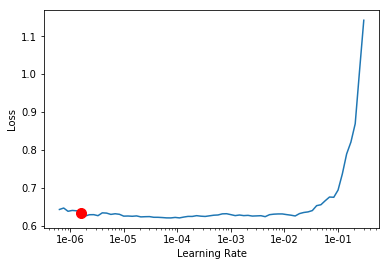

In [14]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(4, slice(5e-5, 5e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.640158,0.675459,0.611005,0.429752,00:40
1,0.631743,0.646810,0.616355,0.469506,00:40
2,0.622174,0.648137,0.609859,0.444382,00:40
3,0.613797,0.642969,0.613298,0.476467,00:40


In [16]:
learner.save('softer_image_droput_0.05-2')

In [17]:
learner.load('softer_image_droput_0.05-2');

In [18]:
# Lower the learning rates. Train a bit more
learner.fit_one_cycle(6, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.616525,0.640063,0.616355,0.487177,00:40
1,0.619213,0.634789,0.621704,0.535526,00:40
2,0.612122,0.642013,0.609477,0.481063,00:40
3,0.606307,0.649870,0.610623,0.495261,00:40
4,0.609222,0.680009,0.615972,0.526067,00:39
5,0.604663,0.685763,0.602598,0.512242,00:39


In [19]:
learner.save('softer_image_droput_0.05-3')

In [20]:
learner.load('softer_image_droput_0.05-3');

In [21]:
# Train using even lower learning rates
learner.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.611044,0.676828,0.609859,0.524651,00:40
1,0.605301,0.700704,0.608712,0.548508,00:40
2,0.598381,0.710374,0.600306,0.511309,00:40
3,0.604082,0.740981,0.595338,0.545802,00:40
4,0.597836,0.768502,0.592281,0.534443,00:40
5,0.593511,0.744827,0.589224,0.550192,00:40
6,0.598773,0.748363,0.601834,0.554747,00:40
7,0.587807,0.794044,0.590371,0.554102,00:40
8,0.583687,0.793057,0.580054,0.543012,00:40
9,0.589682,0.780951,0.596867,0.553318,00:40


In [22]:
learner.save('softer_image_droput_0.05-4')

In [31]:
learner.load('softer_image_droput_0.05-4');

In [32]:
# Increse the dropout strength
learner.model[0].p = 0.06

In [33]:
learner.model[0]

Dropout(p=0.06)

In [34]:
learner.fit_one_cycle(10, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.586839,0.801954,0.582728,0.553482,00:40
1,0.583867,0.822211,0.578525,0.556952,00:40
2,0.576640,0.835889,0.570501,0.558058,00:40
3,0.582932,0.856969,0.583110,0.547614,00:40
4,0.583048,0.867201,0.571647,0.553539,00:41
5,0.580956,0.856791,0.578143,0.555194,00:40
6,0.578588,0.866463,0.576997,0.553143,00:40
7,0.585326,0.911641,0.567826,0.552922,00:41
8,0.565445,0.899377,0.576997,0.555476,00:40
9,0.584457,0.866246,0.570118,0.546552,00:40


In [35]:
learner.save('softer_image_droput_0.06-1')

In [36]:
learner.load('softer_image_droput_0.06-1');

In [37]:
learner.fit_one_cycle(10, slice(9e-7, 9e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.578350,0.882333,0.567826,0.561283,00:40
1,0.572807,0.871191,0.570883,0.557763,00:41
2,0.583601,0.895264,0.569354,0.558152,00:40
3,0.579633,0.929131,0.568590,0.558344,00:40
4,0.586262,0.942425,0.573175,0.555786,00:41
5,0.580763,0.915803,0.573940,0.564391,00:41
6,0.583479,0.945228,0.568590,0.561830,00:40
7,0.579601,0.957947,0.572411,0.552697,00:40
8,0.582580,0.949895,0.569354,0.557463,00:41
9,0.582307,0.962733,0.564387,0.558305,00:41


In [38]:
learner.save('softer_image_droput_0.06-2')

In [39]:
learner.load('softer_image_droput_0.06-2');

In [40]:
learner.model[0].p = 0.07

In [41]:
learner.model[0].p

0.07

In [42]:
learner.fit_one_cycle(15, slice(9e-7, 9e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.576733,1.004590,0.566297,0.560093,00:40
1,0.569231,0.976609,0.561330,0.561489,00:40
2,0.585632,0.948751,0.559419,0.562111,00:41
3,0.571761,0.971959,0.564387,0.564682,00:41
4,0.573482,1.018506,0.555980,0.562454,00:40
5,0.574030,0.963080,0.567062,0.558447,00:40
6,0.571153,1.029437,0.566679,0.559867,00:40
7,0.575310,1.039587,0.570883,0.561655,00:40
8,0.571914,1.015431,0.564387,0.566717,00:40
9,0.561655,1.035952,0.559037,0.565847,00:40


In [43]:
learner.save('softer_image_droput_0.07-1')

In [44]:
learner.load('softer_image_droput_0.07-1');

In [45]:
# Try a larger learning rate
learner.fit_one_cycle(5, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.578367,1.051630,0.556744,0.566715,00:40
1,0.582972,1.043647,0.573557,0.554824,00:40
2,0.578821,1.085840,0.566297,0.560432,00:40
3,0.576142,1.034804,0.566679,0.574655,00:40
4,0.568887,1.088823,0.562094,0.573998,00:40


In [46]:
learner.save('softer_image_droput_0.07-2')

In [48]:
learner.load('softer_image_droput_0.07-2');

In [49]:
learner.model[0].p = 0.01

In [50]:
learner.model[0].p

0.01

In [51]:
learner.fit_one_cycle(5, slice(5e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.579102,0.721621,0.640810,0.537437,00:40
1,0.586642,0.674737,0.646542,0.552520,00:40
2,0.582924,0.681808,0.641574,0.540460,00:40
3,0.573645,0.669520,0.648070,0.549014,00:40
4,0.576755,0.661826,0.656859,0.558509,00:41


In [52]:
learner.save('softer_image_droput_0.01-1')

In [54]:
learner.load('softer_image_droput_0.01-1');

In [55]:
learner.fit_one_cycle(10, slice(5e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.569126,0.668352,0.648835,0.550551,00:40
1,0.565138,0.642797,0.646160,0.548594,00:40
2,0.572976,0.647722,0.649981,0.552859,00:40
3,0.566278,0.633175,0.650745,0.559761,00:40
4,0.580017,0.623617,0.655713,0.564719,00:40
5,0.580801,0.625385,0.652274,0.561094,00:40
6,0.567447,0.616389,0.663737,0.601454,00:41
7,0.561160,0.604038,0.663355,0.585599,00:40
8,0.563415,0.606652,0.663737,0.582180,00:40
9,0.561640,0.608924,0.663355,0.595289,00:40


In [56]:
learner.save('softer_image_droput_0.01-2')

In [59]:
learner.load('softer_image_droput_0.01-2');

In [62]:
learner.model[0].p = 0.0

In [63]:
learner.model[0].p

0.0

In [64]:
learner.fit_one_cycle(15, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.579592,0.591011,0.665266,0.534838,00:40
1,0.575046,0.593814,0.669469,0.535428,00:40
2,0.573897,0.586897,0.672908,0.547856,00:40
3,0.567420,0.594066,0.671379,0.543031,00:40
4,0.573519,0.599426,0.677111,0.559875,00:41
5,0.572219,0.583947,0.673672,0.554140,00:42
6,0.564528,0.595668,0.670233,0.543464,00:46
7,0.559918,0.589356,0.671762,0.542619,00:46
8,0.565193,0.580506,0.679404,0.575910,00:46
9,0.562389,0.578606,0.680550,0.571676,00:46


In [66]:
learner.save('ofter_image_droput_0.00-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.92E-07


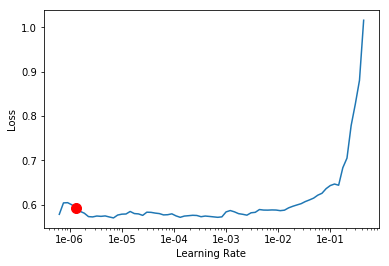

In [67]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [68]:
learner.load('ofter_image_droput_0.00-1')
learner.fit_one_cycle(15, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.565565,0.583314,0.672144,0.547553,00:46
1,0.568134,0.584464,0.678640,0.562541,00:45
2,0.560935,0.579394,0.679404,0.574414,00:46
3,0.570875,0.594932,0.673290,0.556650,00:46
4,0.582555,0.588643,0.670233,0.536966,00:46
5,0.556464,0.609722,0.662209,0.504714,00:46
6,0.569023,0.595774,0.683989,0.587789,00:46
7,0.555970,0.595149,0.667176,0.540166,00:46
8,0.555093,0.588244,0.677111,0.564222,00:46
9,0.541104,0.580622,0.688957,0.584859,00:46


In [69]:
learner.save('softer_image_droput_0.00-2')